In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import requests

In [2]:
#path = 'data/botwiki-2019/botwiki-2019.tsv'
#path = 'data/cresci-rtbust-2019/cresci-rtbust-2019.tsv'
path = 'data/gilani-2017/gilani-2017.tsv'

df = pd.read_csv(path, sep='\t', header=None).rename(columns={0: "twitter_id", 1: 'label'})

df.head()

,twitter_id,label
0,461277906,bot
1,808280162,bot
2,1575510320,bot
3,2449235599,bot
4,1113769100,bot


In [3]:
df.label.value_counts()

human    1522
bot      1130
Name: label, dtype: int64

In [25]:
import tweepy
from tweepy import Client

key = ""
secret = ""
token = ""

api = tweepy.Client(bearer_token=token, consumer_key=key, consumer_secret=secret, 
              return_type=requests.Response,
              wait_on_rate_limit=True)

Get In/Out Degrees of Accounts

In [26]:
r = api.get_user(id=948138399281680384, user_fields='public_metrics')
r.json()

{'data': {'username': 'xSimozzz',
  'name': 'Stonks 🌍',
  'id': '948138399281680384',
  'public_metrics': {'followers_count': 2,
   'following_count': 106,
   'tweet_count': 61,
   'listed_count': 0}}}

In [ ]:
# Get number followers / following
in_degree_list = []
out_degree_list = []
id_list = []
for curr_id, label in zip(df.twitter_id, df.label):
    try:
        r = api.get_user(id=curr_id, user_fields='public_metrics')
        user = r.json()
        
        in_degree_list.append(user['data']['public_metrics']['followers_count'])
        out_degree_list.append(user['data']['public_metrics']['following_count'])
        id_list.append(curr_id)
    except:
        continue

d = {'twitter_id': id_list,
     'followers_count': in_degree_list,
    'following_count': out_degree_list}

deg = pd.DataFrame(d)

In [6]:
deg.drop(index = deg.loc[deg.twitter_id.duplicated()].index, inplace=True)

combined = deg.merge(df, on='twitter_id', how='inner')

combined.drop(index = combined.loc[combined.twitter_id.duplicated()].index, inplace=True)

In [7]:
# Drop accounts with 0 followers
combined.drop(index=combined.loc[combined.followers_count == 0].index, inplace=True)

# Drop accounts with 0 following
combined.drop(index=combined.loc[combined.following_count == 0].index, inplace=True)

Text(500, 2.4, 'Degree Distribution')

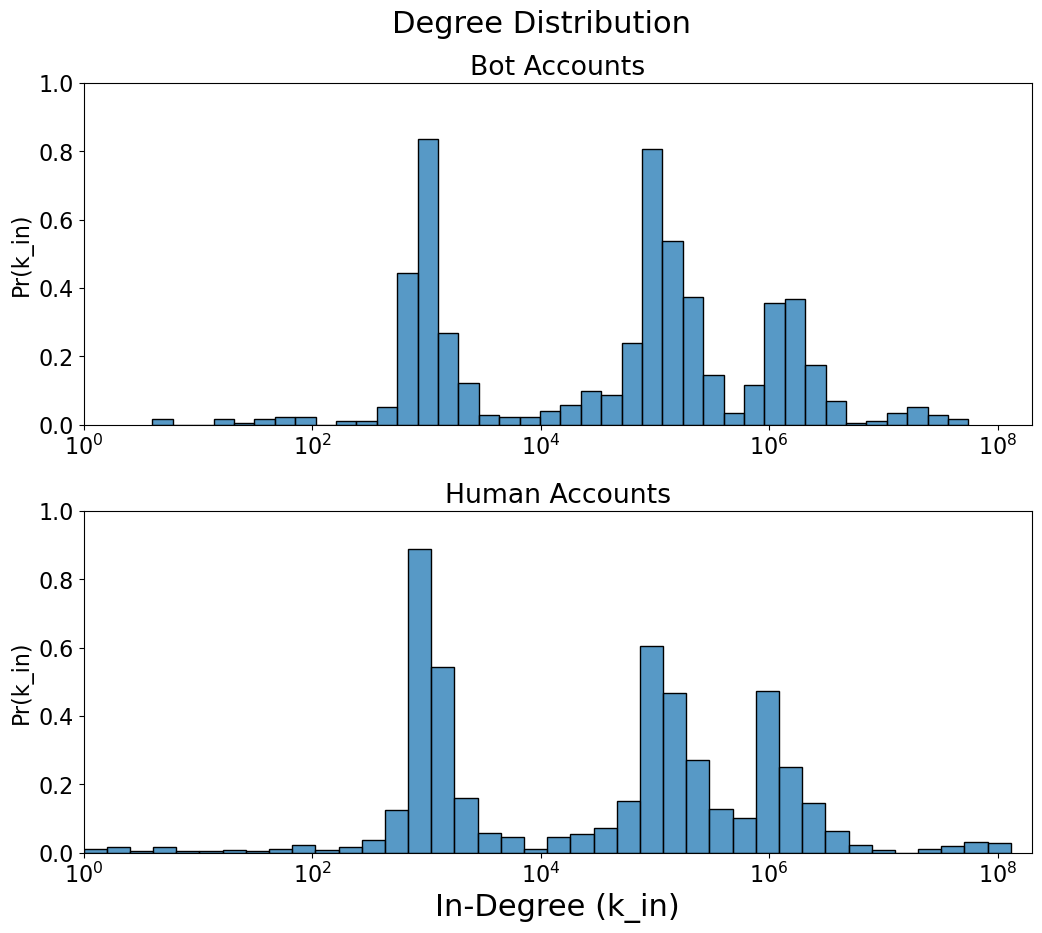

In [264]:
import seaborn as sns
plt.rcParams.update({'font.size': 16})
plt.subplots(2, 1, figsize=(11, 9))
plt.tight_layout(pad=2)

plt.subplot(2, 1, 1)
bots = combined.loc[combined.label == 'bot']
sns.histplot(bots, x='followers_count', bins=40, log_scale=True, stat='density')
plt.xlim([1, 2*10**8])
plt.ylim([0, 1])

plt.xlabel('')
plt.ylabel('Pr(k_in)')
plt.title('Bot Accounts')


plt.subplot(2, 1, 2)
humans = combined.loc[combined.label == 'human']
ax2 = sns.histplot(humans, x='followers_count', bins=40, log_scale=True, stat='density')
ax2.set_xlim([1, 2*10**8])
ax2.set_ylim([0, 1])

plt.ylabel('Pr(k_in)')
plt.xlabel('In-Degree (k_in)', fontsize=22)
plt.title('Human Accounts')
plt.text(500, 2.4, 'Degree Distribution', fontsize=22)


Text(180, 2.4, 'Degree Distribution')

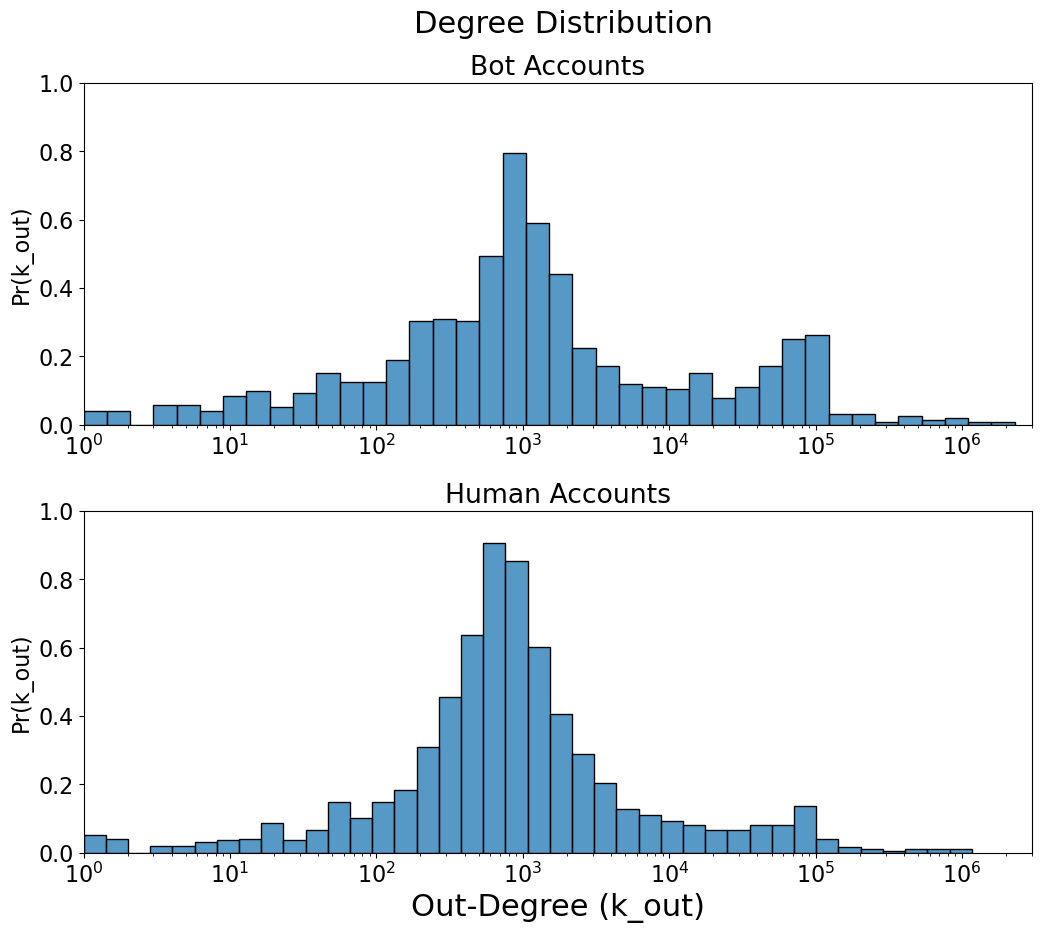

In [270]:
plt.subplots(2, 1, figsize=(11, 9))
plt.tight_layout(pad=2)

plt.subplot(2, 1, 1)
bots = combined.loc[combined.label == 'bot']
sns.histplot(bots, x='following_count', bins=40, log_scale=True, stat='density')
plt.xlim([1, 3*10**6])
plt.ylim([0, 1])

plt.xlabel('')
plt.ylabel('Pr(k_out)')
plt.title('Bot Accounts')


plt.subplot(2, 1, 2)
humans = combined.loc[combined.label == 'human']
ax2 = sns.histplot(humans, x='following_count', bins=40, log_scale=True, stat='density')
ax2.set_xlim([1, 3*10**6])
ax2.set_ylim([0, 1])

plt.ylabel('Pr(k_out)')
plt.xlabel('Out-Degree (k_out)', fontsize=22)
plt.title('Human Accounts')
plt.text(180, 2.4, 'Degree Distribution', fontsize=22)

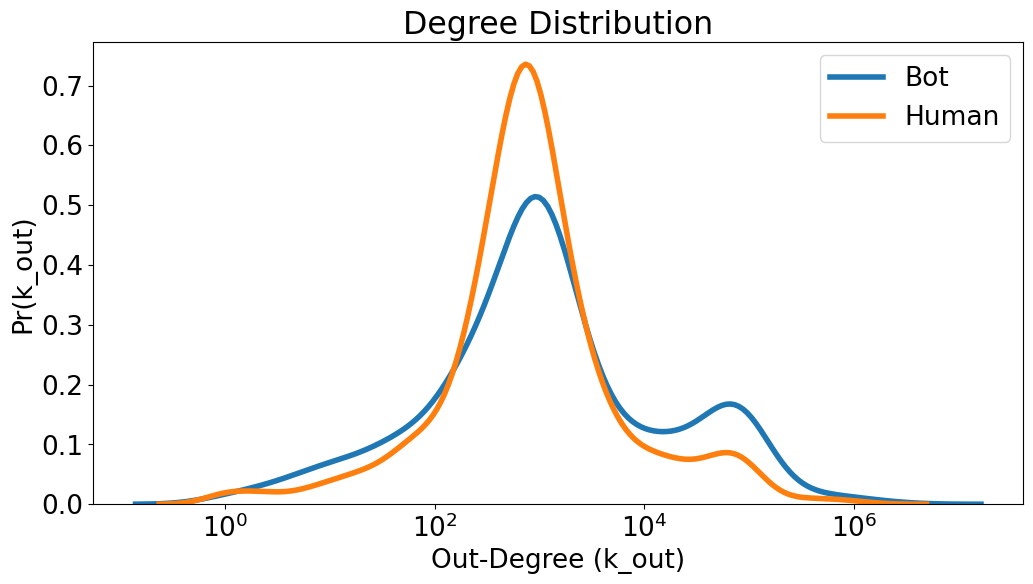

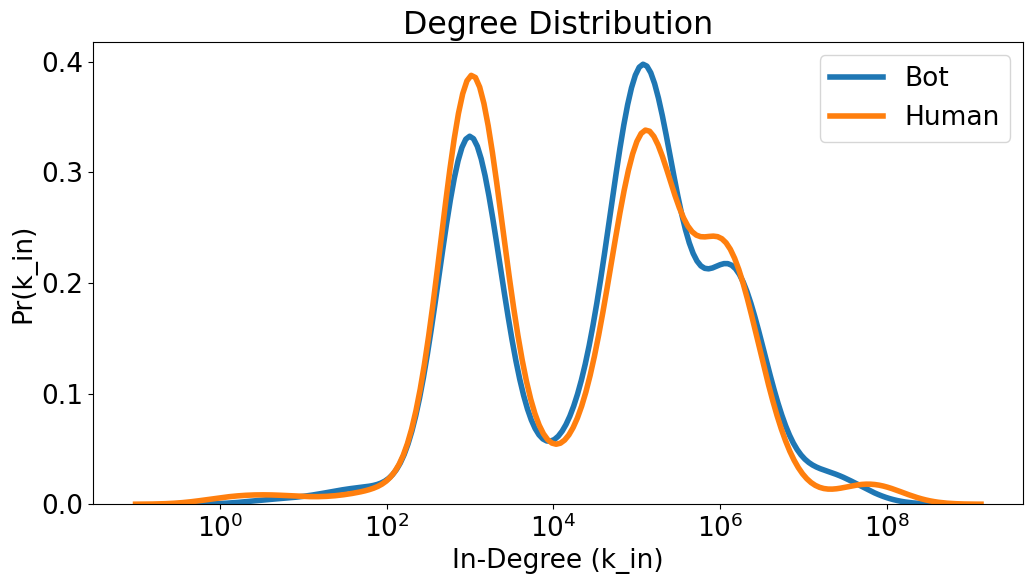

In [329]:
plt.rcParams.update({'font.size': 19})
plt.figure(figsize=(12, 6))
sns.kdeplot(x=bots['following_count'] , log_scale=True, label='Bot', linewidth=4)
sns.kdeplot(humans['following_count'], log_scale=True, label='Human', linewidth=4)
plt.xlabel('Out-Degree (k_out)')
plt.ylabel('Pr(k_out)')
plt.title('Degree Distribution')
plt.legend()


plt.rcParams.update({'font.size': 19})
plt.figure(figsize=(12, 6))
sns.kdeplot(x=bots['followers_count'] , log_scale=True, label='Bot', linewidth=4)
sns.kdeplot(x=humans['followers_count'], log_scale=True, label='Human', linewidth=4)
plt.xlabel('In-Degree (k_in)')
plt.ylabel('Pr(k_in)')
plt.title('Degree Distribution')
plt.legend()

Text(0.5, 1.05, 'Degree Distribution: In-Degree vs. Out-Degree')

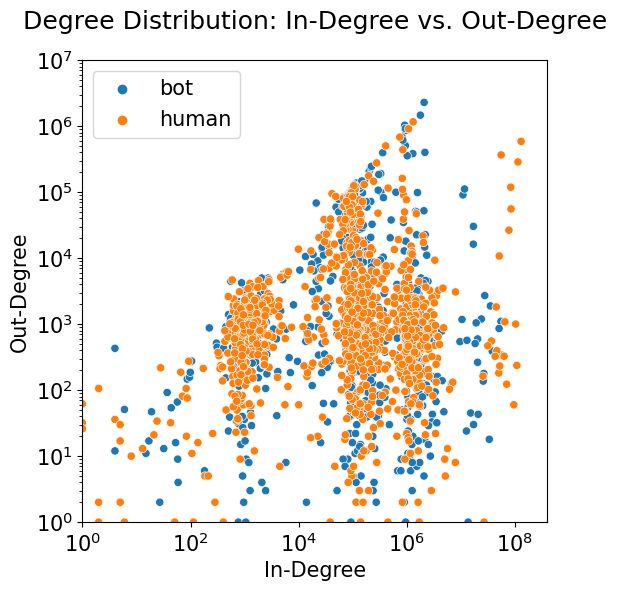

In [328]:
# 2D scatterplot
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(data=combined, x='followers_count', y='following_count', hue='label')
ax.set(xscale="log", yscale='log')
plt.xlim([1, 4*10**8])
plt.ylim([1, 10**7])
plt.xlabel('In-Degree')
plt.ylabel('Out-Degree')
plt.legend(fontsize=15, loc=2)

plt.title('Degree Distribution: In-Degree vs. Out-Degree', y=1.05)

In [2]:
#combined.to_pickle('node_and_degree_list.pkl')

In [5]:
combined = pd.read_pickle('node_and_degree_list.pkl')

In [6]:
thresh = 1000

In [8]:
print('BEFORE FILTERING')
print(f'Total accounts: {combined.shape[0]}')
nb = combined.loc[combined.label == 'bot'].shape[0]
nh = combined.loc[combined.label == 'human'].shape[0]
print(f'Bot accounts: {nb}')
print(f'Human accounts: {nh}')
print('____________________')


# Drop
small = combined.loc[combined.followers_count < thresh]
small = small.loc[small.followers_count < thresh]

print('AFTER FILTERING')
print(f'Total accounts: {small.shape[0]}')
nb = small.loc[small.label == 'bot'].shape[0]
nh = small.loc[small.label == 'human'].shape[0]
print(f'Bot accounts: {nb}')
print(f'Human accounts: {nh}')

BEFORE FILTERING
Total accounts: 2263
Bot accounts: 959
Human accounts: 1304
____________________
AFTER FILTERING
Total accounts: 458
Bot accounts: 193
Human accounts: 265


In [11]:
import os

already_processed = []
 
for name in os.listdir('bot'):
    if os.path.isdir(name):
        continue
    list_name = name.replace('.pkl','').replace('edgelist_2_edges_from_start_','')
    already_processed.append(int(list_name))

In [102]:
small = small.loc[small.label == 'bot']
small['total_follows'] = small.following_count + small.followers_count

small = small.sort_values(by='total_follows', ascending=True)

In [138]:
small.loc[small.total_follows > 100]

,twitter_id,followers_count,following_count,label,total_follows
473,2385417602,57,66,bot,123
429,1004764640486854656,37,92,bot,129
83,837316817324556289,182,6,bot,188
137,913028718377005056,87,147,bot,234
412,1416121214,96,155,bot,251
...,...,...,...,...,...
495,3166813130,923,2108,bot,3031
743,327422553,994,3053,bot,4047
492,2861336274,967,3206,bot,4173
689,4880154665,558,4451,bot,5009


In [12]:
small.head()

,twitter_id,followers_count,following_count,label
24,4307623643,59,4,bot
36,844779426260791296,768,1,bot
83,837316817324556289,182,6,bot
137,913028718377005056,87,147,bot
175,790017240733278208,19,47,bot


In [145]:
subset = small.loc[small.total_follows >350]

In [19]:
# Create curr_edgelist for a network including nodes up to 3 degrees of separation (3 links away)
def add_this_nodes_edgelist(this_acc, curr_edgelist):
    next_page_token = None
    visited.add(this_acc)

    action = 'followers'
    follow_list = []
    this_acc_num_following = []    
    this_acc_num_followers = []
    while True:
        # Get immediate followers/following of node and add these to curr_edgelist
        if action == 'followers':
            request = api.get_users_followers(id=this_acc, user_auth=False, 
                max_results=1000, pagination_token=next_page_token, user_fields=['public_metrics'])
        elif action == 'following':
            request = api.get_users_following(id=this_acc, user_auth=False, 
                max_results=1000, pagination_token=next_page_token, user_fields=['public_metrics'])

        data = request.json()

        # for each account following/followed by the originating account, record account id, 
        # num following, and num followed by
        try:
            for acc in data['data']:
                follow_list.append(acc['id'])
                num_following = acc['public_metrics']['following_count']
                num_followed_by = acc['public_metrics']['followers_count']
                this_acc_num_following.append(num_following)
                this_acc_num_followers.append(num_followed_by)

            this_acc_list = [this_acc for i in range(len(follow_list))]

        # Catch errors if not authorized to view user
        except Exception as e:
            print('Exception: issue retrieving follow lists for this account -- Skipping')
            print('Data:')
            print(data)
            return curr_edgelist
            
            
        if 'next_token' in data['meta'].keys():    # get page token for next request
                next_page_token = data['meta']['next_token']
        
        # when all data recorded transition to next action
        else:
            next_page_token = None
            if action == 'followers':
                d = {'originating_id': follow_list,
                    'receiving_id': this_acc_list,
                    'originating_following_count': this_acc_num_following, 
                    'originating_follower_count': this_acc_num_followers}
                edges_to_add = pd.DataFrame(d)
                curr_edgelist = pd.concat([curr_edgelist, edges_to_add])

                action = 'following'

                # reset lists
                follow_list = []
                this_acc_num_following = []    
                this_acc_num_followers = []

            elif action == 'following':
                d = {'originating_id': this_acc_list,
                    'receiving_id': follow_list,
                    'receiving_following_count': this_acc_num_following, 
                    'receiving_follower_count': this_acc_num_followers}
                edges_to_add = pd.DataFrame(d)
                curr_edgelist = pd.concat([curr_edgelist, edges_to_add])

                next_page_token = None

                return curr_edgelist

In [20]:
def transition_to_next_separation_degree(curr_edgelist, degrees_of_separation):
    try:
        # Drop all nodes with followers or following more than threshold
        to_drop = (curr_edgelist.originating_following_count > thresh) | \
            (curr_edgelist.originating_follower_count > thresh) | \
            (curr_edgelist.receiving_following_count > thresh) | \
            (curr_edgelist.receiving_follower_count > thresh)
        curr_edgelist.drop(index = curr_edgelist[to_drop].index, inplace=True)

        # create list of all neighbors in curr_edgelist df
        unvisited_neighbors = list(curr_edgelist.originating_id.append(curr_edgelist.receiving_id).unique())

        # if any nodes are in visited set, remove
        [unvisited_neighbors.remove(i) for i in unvisited_neighbors if i in visited]

        print()
        print(f'Current Number of edges from starting node {degrees_of_separation}')
        print(f'Num unvisited neighbors: {len(unvisited_neighbors)}')
        print('--------------------')
        degrees_of_separation +=1 
    
        return curr_edgelist, degrees_of_separation, unvisited_neighbors
    
    
    except Exception as e:
        print(e)
        print('--------------------EXCEPTION--------------------')
        return curr_edgelist, degrees_of_separation, []
        
    

In [121]:
already_processed = [1016773517587537920,
 837316817324556289,
 4307623643,
 844779426260791296,
 790017240733278208,
 913028718377005056,
 2855732920,
 1416121214,
 821215184660393986,
 1004764640486854656,
 352132252,
 1661404440,
 2928556470,
 2901953015,
1058130850578137089]

In [22]:
already_processed

[1005564252948582401,
 1030869656666599424,
 1661404440,
 747958680386179072,
 1416121214,
 821215184660393986,
 729462247647551488,
 352132252,
 837316817324556289,
 875984489138200577,
 1004764640486854656,
 1058130850578137089,
 2928556470,
 2901953015,
 2385417602,
 4459687272]

In [23]:
cols=['originating_id', 'receiving_id', 
          'originating_following_count', 'originating_follower_count',
         'receiving_following_count', 'receiving_follower_count']
    
for starting_acc, label in zip(small.twitter_id, small.label):
    if starting_acc in already_processed:
        continue
    print(f'Starting node == {starting_acc}')
    # Initialization code for populating edgelist starting from node specified by "starting_acc"
    edgelist = pd.DataFrame(columns=cols)

    degrees_of_separation = 0

    visited = set()
    visited.add(starting_acc)

    edgelist = add_this_nodes_edgelist(starting_acc, edgelist) 
    edgelist, degrees_of_separation, unvisited_neighbors = transition_to_next_separation_degree(edgelist, degrees_of_separation)
    
    # iterate thru all unvisited neighbors with Xth degree of separation from starting (labeled) node
    # process df in chunks before concatenating
    while degrees_of_separation <= 1:
        curr_edgelist = pd.DataFrame(columns=cols)
        for i, neighbor in enumerate(unvisited_neighbors):
            print(f'{i}: {neighbor}')
            curr_edgelist = add_this_nodes_edgelist(neighbor, curr_edgelist)
            visited.add(neighbor)
        
        curr_edgelist, degrees_of_separation, unvisited_neighbors = transition_to_next_separation_degree(curr_edgelist, degrees_of_separation)
        edgelist = pd.concat([edgelist, curr_edgelist])

    fn = 'edgelist_2_edges_from_start_' + str(starting_acc) + '.pkl'
    path = str(label) + '/' + fn
    edgelist.to_pickle(path)
    
    already_processed.append(starting_acc)

Starting node == 4307623643

Current Number of edges from starting node 0
Num unvisited neighbors: 43
--------------------
0: 975769275435634689
1: 714797133895831552
2: 3189052495
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '3189052495', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '3189052495', 'detail': 'Sorry, you are not authorized to see the user with id: [3189052495].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
3: 4920442812
4: 711683905414418433
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '711683905414418433', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '711683905414418433', 'detail': 'Sorry, you are not authorized to see the user with id: [711683905414418433].', 'type': 'https://api.twitter.com/2/problems/not

Rate limit exceeded. Sleeping for 895 seconds.


Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '880924179477831681', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '880924179477831681', 'detail': 'Sorry, you are not authorized to see the user with id: [880924179477831681].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
14: 2945116200


KeyboardInterrupt: 

In [132]:
starting_acc = 837316817324556289

print(f'Starting node == {starting_acc}')
# Initialization code for populating edgelist starting from node specified by "starting_acc"
edgelist = pd.DataFrame(columns=cols)

degrees_of_separation = 0

visited = set()
visited.add(starting_acc)

edgelist = add_this_nodes_edgelist(starting_acc, edgelist) 
edgelist, degrees_of_separation, unvisited_neighbors = transition_to_next_separation_degree(edgelist, degrees_of_separation)

while degrees_of_separation <= 1:
        curr_edgelist = pd.DataFrame(columns=cols)
        for i in unvisited_neighbors:
            print(f'{i}: {neighbor}')
            curr_edgelist = add_this_nodes_edgelist(i, curr_edgelist)
            visited.add(i)
        
        curr_edgelist, degrees_of_separation, unvisited_neighbors = transition_to_next_separation_degree(curr_edgelist, degrees_of_separation)
        edgelist = pd.concat([edgelist, curr_edgelist])

fn = 'edgelist_2_edges_from_start_' + str(starting_acc) + '.pkl'
path = str(label) + '/' + fn
edgelist.to_pickle(path)

already_processed.append(starting_acc)

Starting node == 837316817324556289


Rate limit exceeded. Sleeping for 221 seconds.



Current Number of edges from starting node 0
Num unvisited neighbors: 147
--------------------
1281537400598978560: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '1281537400598978560', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '1281537400598978560', 'detail': 'Sorry, you are not authorized to see the user with id: [1281537400598978560].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
3187614895: 4528328705
1165464856373280769: 4528328705
1117423293936463873: 4528328705
1306606006978228225: 4528328705
1290854729820467205: 4528328705
1266917739412635649: 4528328705
1234416142015483904: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'meta': {'result_count': 0}}
3796160488: 4528328705
1116569746437074947: 4528328705
1247712604052750339: 4528328705
Exception: issue retrieving follow lists fo

Rate limit exceeded. Sleeping for 896 seconds.


1108150143671373825: 4528328705
1081217138898030597: 4528328705
989916067261693952: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '989916067261693952', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '989916067261693952', 'detail': 'Sorry, you are not authorized to see the user with id: [989916067261693952].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
605466022: 4528328705
1212530264695398400: 4528328705
748842814243414016: 4528328705
570061976: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '570061976', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '570061976', 'detail': 'Sorry, you are not authorized to see the user with id: [570061976].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-re

Rate limit exceeded. Sleeping for 895 seconds.


330204993: 4528328705
164523308: 4528328705
866989357009448960: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '866989357009448960', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '866989357009448960', 'detail': 'Sorry, you are not authorized to see the user with id: [866989357009448960].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
1020314646903848961: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '1020314646903848961', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '1020314646903848961', 'detail': 'Sorry, you are not authorized to see the user with id: [1020314646903848961].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
890909148010864641: 4528328705
Exception: issue retrie

Rate limit exceeded. Sleeping for 895 seconds.


1168532220014817282: 4528328705
2278446908: 4528328705
232855168: 4528328705
257889289: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '257889289', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '257889289', 'detail': 'Sorry, you are not authorized to see the user with id: [257889289].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
2883196181: 4528328705
134762876: 4528328705
1016306885610299392: 4528328705
769677805: 4528328705
2565238256: 4528328705
1002531636175519744: 4528328705
56058127: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '56058127', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '56058127', 'detail': 'Sorry, you are not authorized to see the user with id: [56058127].', 'type': 'https://api.tw

Rate limit exceeded. Sleeping for 895 seconds.


2922115093: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '2922115093', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '2922115093', 'detail': 'Sorry, you are not authorized to see the user with id: [2922115093].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
1072120508454330369: 4528328705
1145653278690070529: 4528328705
871699688113684480: 4528328705
1053675220605657088: 4528328705
15717170: 4528328705
891229860290605060: 4528328705
794356868: 4528328705
963402565512708096: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '963402565512708096', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '963402565512708096', 'detail': 'Sorry, you are not authorized to see the user with id: [963402565512708096].', 'type': '

Rate limit exceeded. Sleeping for 894 seconds.


809029471952977920: 4528328705
1143244675639369730: 4528328705
710427972621225984: 4528328705
41987746: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '41987746', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '41987746', 'detail': 'Sorry, you are not authorized to see the user with id: [41987746].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
1058588435131248641: 4528328705
368839227: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '368839227', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '368839227', 'detail': 'Sorry, you are not authorized to see the user with id: [368839227].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
841685203391270912: 4528328705
182627012: 4528328705

Rate limit exceeded. Sleeping for 895 seconds.


1290475934: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '1290475934', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '1290475934', 'detail': 'Sorry, you are not authorized to see the user with id: [1290475934].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
53641002: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '53641002', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '53641002', 'detail': 'Sorry, you are not authorized to see the user with id: [53641002].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
1062998738: 4528328705
138802204: 4528328705
1106098864556146688: 4528328705
2363853212: 4528328705
319479183: 4528328705
389921727: 4528328705
2670218297: 4528328705
1709195

Rate limit exceeded. Sleeping for 892 seconds.


113619504: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '113619504', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '113619504', 'detail': 'Sorry, you are not authorized to see the user with id: [113619504].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
330435751: 4528328705
4178932520: 4528328705
1432130275: 4528328705
963012594352103425: 4528328705
810092741682024448: 4528328705
135827871: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '135827871', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '135827871', 'detail': 'Sorry, you are not authorized to see the user with id: [135827871].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
331361598: 4528328705
967898330: 4528328705


Rate limit exceeded. Sleeping for 895 seconds.


508713845: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '508713845', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '508713845', 'detail': 'Sorry, you are not authorized to see the user with id: [508713845].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
2834192498: 4528328705
3201415743: 4528328705
2775664496: 4528328705
1152528361832345600: 4528328705
3236677135: 4528328705
1016951884819525632: 4528328705
939176178820272128: 4528328705
55416872: 4528328705
1563811292: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '1563811292', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '1563811292', 'detail': 'Sorry, you are not authorized to see the user with id: [1563811292].', 'type': 'https://api.twitter.com/2/pro

Rate limit exceeded. Sleeping for 894 seconds.


532921978: 4528328705
838058262654300160: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '838058262654300160', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '838058262654300160', 'detail': 'Sorry, you are not authorized to see the user with id: [838058262654300160].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
519339817: 4528328705
Exception: issue retrieving follow lists for this account -- Skipping
Data:
{'errors': [{'resource_id': '519339817', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '519339817', 'detail': 'Sorry, you are not authorized to see the user with id: [519339817].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}
920842094: 4528328705
1083488737387053057: 4528328705
1184249605: 4528328705
2525319283: 4528328705
Exception: issue